## FASTAI Example using call backs


## Classes used


1. Dataset - contains the x and y data for a particular data set, i.e. the validation set

2. DataLoader - this is an class which contains a dataset and can return a specific number of items from the dataset (usually using an iterator). Takes a Sampler object (which itself an be iterated over) to tell the DataLoader how to give the return the data when iterated over (i.e. sequential, random). Contains a collate function which shows how to package the data (I think this can add padding and perform transformations). 

3. Sampler - class of how to iterate over the data . This contains the data length of the dataset and the batch size. It bascially returns the indexes of the dataset to return

4. DataBunch - contains all dataLoaders assocaited with a dataset, the batch size and the number of inputs into the initial layer. It is just a wrapper to keep all the data together. 

5. Model - Contains the network layers. The __call__ attribute runs the forward pass. This inherits from nn.module. All layers are stored and can be accessed via Model.parameters() function. The network layers can be given as a list of layer classes

6. Optimizer - contains the logic steps of the backward pass as functions. 

7. Learner - A wrapper that contains the data bunch, model, optimizer and loss function. This is just a wrapper

8. Callback - this is the super class for any call back. It contains default functions for all the callback insertions in the model. These can be over-ridden in the derived classes. The begin_it method adds the learner to the callback

9. CallbackHander - runs all methods in all call backs and runs them at the appropiate point in the model

10. Runner - The runner class contains all aspects to run the code. The init function takes any call back handlers
    Contains 4 methods. . Effectively the __call__ function is used to run through call backs and call them at the correct time
        i) one_batch(x, y) - performs a complete step through a single data data, including updating the weights. Contains the begin_batch, after_pred, after_loss, after_backward and after_step call backs.
        ii) all_batches(data_loader) - iterates through all batches (calling the one_batch method). Contains the after_batch call back. Loops through the data loader passing the x and y data of each batch to the one_batch method
        iii) fit(epochs, learn) - takes a learner object and the number of epochs. The optimiser, loss function, model and data become members of the learner class using property decorators
  

## Functions

1. get_dls()
2. get_model()

In [1]:
#h = True#
#hh = 3 if h else hh = 5

## Load stuff

In [2]:
#export
%load_ext autoreload
%autoreload 2

%matplotlib inline

#export
from exp.nb_02 import *
import torch.nn.functional as F # all nn functions
import torch.nn as nn

#export
from exp.nb_03 import *

## DataLoader class, sampler class and collate function

In [3]:
#export
# Sampler class
class SamplerDJ():
    def __init__(self, ds, bs, shuffle = False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
    
    def __iter__(self):
        if self.shuffle:
            self.dx = torch.randperm(self.n)
        else:
            self.dx = torch.arange(self.n)
        for idx in range(0, self.n, self.bs):
            yield self.dx[idx:idx + bs]
            
# Collate function
def collateDJ(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoaderDJ():
    def __init__(self, ds, smp, bs, collate = collateDJ):
        self.ds, self.smp, self.bs, self.collate = ds, smp, bs, collate
        
    def __iter__(self): # returns a data batch
        for sdx in self.smp:
            yield self.collate(([self.ds[i] for i in sdx]))
        
    def __len__(self): # returns number of batches
            return len(self.ds)//self.bs


## Databunch class

In [4]:
#export
class DataBunchDJ():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c # c is final number of acitvations
        
    @property
    def train_ds(self): return self.train_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

## Learner class

In [5]:
#export
class LearnerDJ():
    def __init__(self, db, model, opt, lossFunc):
        self.db, self.model, self.opt, self.lossFunc = db, model, opt, lossFunc
        

## Model class

In [6]:
#export
class ModelDJ(nn.Module):  
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

## Optimizer

In [7]:
#export
class OptimizerDJ():
    def __init__(self, params, lr): # params are from the model
        self.lr, self.params = lr, list(params)
        
    def step(self): # step through back ward pass
        with torch.no_grad():
            for dx in self.params:
                dx -= dx.grad*self.lr
    
    def zero_grad(self): # zero gradient
        for dx in self.params:
            dx.grad.data.zero_()
        
        

## Call back base calls

In [8]:
#export
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k) # gets the object from self.run
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')



## TrainEvalCallBack - class that allows runner to do certain operations

In [9]:
#export
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        print("Iter: " + str(self.run.n_iter))
        
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True
        print("Epoch: " + str(self.run.epochs))
        self.run.n_iter = 0

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False
        



## Steps and call backs

- begin_fit (before epoch for loop )

1) Begin epoch
    -begin_epoch (inside epoch for loop)
    
    
    2) Begin Training

        3) load a training batch
            -begin_batch (once data is loaded)

            4) Run model (get predictions)
                -after_pred (once model is run)
            
            5) calculate loss
                -after_loss (once loss is calculated)
                
            6) Calculate gradients (backward pass)
                -after_backward
            
            7) Update weights
                -after_step

            8) Zero grads
                -after_batch

    9) begin Validion
        -begin_validate
        10) load a validation batch
             -begin_batch
            11) Run model
            -after_preds
            12) Calculate loss
            
        13) Sum validation loss
        -after_epoch
        

## Runner class

In [10]:
#export
from typing import *

def listify(o): # converts an iterator to a list
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]


# 

# runner class
class RunnerDJ():
    # init takes in call backs, assigns to a list
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs) # make a list of the call backs
        #print(cbs)s
        #print(cb_funcs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            print(cb.name)
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs
    
    # These are the learner members, allows self. to be used inside the runner to access them
    @property
    def opt(self): return self.learn.opt
    @property
    def model(self): return self.learn.model
    @property
    def loss_func(self): return self.learn.lossFunc
    @property
    def data(self): return self.learn.db
        
    def one_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        if self('begin_batch'): return # if call back function returns TRUE then return from method
        # training
        self.pred = model(self.xb) # predictions
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb) # loss function
        #print(self.loss)
        if self('after_loss') or not self.in_train: return
        # Backward pass
        self.loss.backward() # backwad function
        if self('after_backward'): return
        self.opt.step() #
        if self('after_step') : return
        self.opt.zero_grad() # zero gradients
        
        
        
        # valiation
        
    def all_batches(self, dl):
        self.iters = len(dl)
        for xb, yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop = False
        
    def fit(self, epochs, learn):
        self.epochs,self.learn = epochs,learn
        
        try:
            for cb in self.cbs: cb.set_runner(self) # loops through call backs and tells them what learner they're in

            # If you need a runner member varible then you can get it in the callback
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl) # forward pass run if begin_epoch doesn't return 0

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl) # backward pass
                if self('after_epoch'): break
            
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name): # calls the call back
        #print(cb_name)
        for cb in sorted(self.cbs, key=lambda x: x._order): # sorts call backs by order
            f = getattr(cb, cb_name, None) # if the cb has a cb_name function then get it
            if f and f(): return True
        return False

## Callbacks

In [11]:
#export

class AvgStats():
    def __init__(self, metrics, in_train): 
        self.metrics,self.in_train = listify(metrics),in_train
        #print("Metrics:")
        #print(metrics)
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn # can have any metrics on the predictions and truth 

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): 
            stats.accumulate(self.run) # passes the runner in 
            #print(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)


## Data

In [12]:
# Load the data

x_train,y_train,x_valid,y_valid = get_data() # function to load the data
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid) # dataset classes
nh,bs = 50,64
c = y_train.max().item()+1 # output nodes
loss_func = F.cross_entropy # cross entropy
n, m = x_train.shape


bs = 50 # batch size
nh = 64 # number of hidden layers

# Create samplers
train_smp = SamplerDJ(train_ds, bs, shuffle = True)
valid_smp = SamplerDJ(valid_ds, bs, shuffle = False)

# Create data loaders
train_dl = DataLoaderDJ(train_ds, train_smp, bs)
valid_dl = DataLoaderDJ(valid_ds, valid_smp, bs)

# Create data bunch
db = DataBunchDJ(train_dl, valid_dl, c = c)


# Create model
layers = [nn.Linear(m, nh), nn.ReLU(nh), nn.Linear(nh, c)]

model = ModelDJ(layers)

# Create optimizer
opt = OptimizerDJ(model.parameters(), lr = 0.5)


# Create learner
learn = LearnerDJ(db, model, opt, loss_func)

# Create runner
run = RunnerDJ()
stats = AvgStatsCallback([accuracy])
run = RunnerDJ(cbs=stats) # call backs are seperate objects to the runner - 
#runner just calls their functions and updats them

# Create callbacks

p = iter(model.parameters())
next(p)
#out = run.fit(1, learn)
model.layers

ModuleList(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU(inplace)
  (2): Linear(in_features=64, out_features=10, bias=True)
)

In [13]:
run.fit(4, learn)


Epoch: 4
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Iter: 10
Iter: 11
Iter: 12
Iter: 13
Iter: 14
Iter: 15
Iter: 16
Iter: 17
Iter: 18
Iter: 19
Iter: 20
Iter: 21
Iter: 22
Iter: 23
Iter: 24
Iter: 25
Iter: 26
Iter: 27
Iter: 28
Iter: 29
Iter: 30
Iter: 31
Iter: 32
Iter: 33
Iter: 34
Iter: 35
Iter: 36
Iter: 37
Iter: 38
Iter: 39
Iter: 40
Iter: 41
Iter: 42
Iter: 43
Iter: 44
Iter: 45
Iter: 46
Iter: 47
Iter: 48
Iter: 49
Iter: 50
Iter: 51
Iter: 52
Iter: 53
Iter: 54
Iter: 55
Iter: 56
Iter: 57
Iter: 58
Iter: 59
Iter: 60
Iter: 61
Iter: 62
Iter: 63
Iter: 64
Iter: 65
Iter: 66
Iter: 67
Iter: 68
Iter: 69
Iter: 70
Iter: 71
Iter: 72
Iter: 73
Iter: 74
Iter: 75
Iter: 76
Iter: 77
Iter: 78
Iter: 79
Iter: 80
Iter: 81
Iter: 82
Iter: 83
Iter: 84
Iter: 85
Iter: 86
Iter: 87
Iter: 88
Iter: 89
Iter: 90
Iter: 91
Iter: 92
Iter: 93
Iter: 94
Iter: 95
Iter: 96
Iter: 97
Iter: 98
Iter: 99
Iter: 100
Iter: 101
Iter: 102
Iter: 103
Iter: 104
Iter: 105
Iter: 106
Iter: 107
Iter: 108
Iter: 109
Iter: 110

Iter: 924
Iter: 925
Iter: 926
Iter: 927
Iter: 928
Iter: 929
Iter: 930
Iter: 931
Iter: 932
Iter: 933
Iter: 934
Iter: 935
Iter: 936
Iter: 937
Iter: 938
Iter: 939
Iter: 940
Iter: 941
Iter: 942
Iter: 943
Iter: 944
Iter: 945
Iter: 946
Iter: 947
Iter: 948
Iter: 949
Iter: 950
Iter: 951
Iter: 952
Iter: 953
Iter: 954
Iter: 955
Iter: 956
Iter: 957
Iter: 958
Iter: 959
Iter: 960
Iter: 961
Iter: 962
Iter: 963
Iter: 964
Iter: 965
Iter: 966
Iter: 967
Iter: 968
Iter: 969
Iter: 970
Iter: 971
Iter: 972
Iter: 973
Iter: 974
Iter: 975
Iter: 976
Iter: 977
Iter: 978
Iter: 979
Iter: 980
Iter: 981
Iter: 982
Iter: 983
Iter: 984
Iter: 985
Iter: 986
Iter: 987
Iter: 988
Iter: 989
Iter: 990
Iter: 991
Iter: 992
Iter: 993
Iter: 994
Iter: 995
Iter: 996
Iter: 997
Iter: 998
Iter: 999
Iter: 1000
train: [0.28825328125, tensor(0.9119)]
valid: [0.1512415283203125, tensor(0.9553)]
Epoch: 4
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Iter: 10
Iter: 11
Iter: 12
Iter: 13
Iter: 14
Iter: 15
Iter: 16
It

Iter: 756
Iter: 757
Iter: 758
Iter: 759
Iter: 760
Iter: 761
Iter: 762
Iter: 763
Iter: 764
Iter: 765
Iter: 766
Iter: 767
Iter: 768
Iter: 769
Iter: 770
Iter: 771
Iter: 772
Iter: 773
Iter: 774
Iter: 775
Iter: 776
Iter: 777
Iter: 778
Iter: 779
Iter: 780
Iter: 781
Iter: 782
Iter: 783
Iter: 784
Iter: 785
Iter: 786
Iter: 787
Iter: 788
Iter: 789
Iter: 790
Iter: 791
Iter: 792
Iter: 793
Iter: 794
Iter: 795
Iter: 796
Iter: 797
Iter: 798
Iter: 799
Iter: 800
Iter: 801
Iter: 802
Iter: 803
Iter: 804
Iter: 805
Iter: 806
Iter: 807
Iter: 808
Iter: 809
Iter: 810
Iter: 811
Iter: 812
Iter: 813
Iter: 814
Iter: 815
Iter: 816
Iter: 817
Iter: 818
Iter: 819
Iter: 820
Iter: 821
Iter: 822
Iter: 823
Iter: 824
Iter: 825
Iter: 826
Iter: 827
Iter: 828
Iter: 829
Iter: 830
Iter: 831
Iter: 832
Iter: 833
Iter: 834
Iter: 835
Iter: 836
Iter: 837
Iter: 838
Iter: 839
Iter: 840
Iter: 841
Iter: 842
Iter: 843
Iter: 844
Iter: 845
Iter: 846
Iter: 847
Iter: 848
Iter: 849
Iter: 850
Iter: 851
Iter: 852
Iter: 853
Iter: 854
Iter: 855


Iter: 654
Iter: 655
Iter: 656
Iter: 657
Iter: 658
Iter: 659
Iter: 660
Iter: 661
Iter: 662
Iter: 663
Iter: 664
Iter: 665
Iter: 666
Iter: 667
Iter: 668
Iter: 669
Iter: 670
Iter: 671
Iter: 672
Iter: 673
Iter: 674
Iter: 675
Iter: 676
Iter: 677
Iter: 678
Iter: 679
Iter: 680
Iter: 681
Iter: 682
Iter: 683
Iter: 684
Iter: 685
Iter: 686
Iter: 687
Iter: 688
Iter: 689
Iter: 690
Iter: 691
Iter: 692
Iter: 693
Iter: 694
Iter: 695
Iter: 696
Iter: 697
Iter: 698
Iter: 699
Iter: 700
Iter: 701
Iter: 702
Iter: 703
Iter: 704
Iter: 705
Iter: 706
Iter: 707
Iter: 708
Iter: 709
Iter: 710
Iter: 711
Iter: 712
Iter: 713
Iter: 714
Iter: 715
Iter: 716
Iter: 717
Iter: 718
Iter: 719
Iter: 720
Iter: 721
Iter: 722
Iter: 723
Iter: 724
Iter: 725
Iter: 726
Iter: 727
Iter: 728
Iter: 729
Iter: 730
Iter: 731
Iter: 732
Iter: 733
Iter: 734
Iter: 735
Iter: 736
Iter: 737
Iter: 738
Iter: 739
Iter: 740
Iter: 741
Iter: 742
Iter: 743
Iter: 744
Iter: 745
Iter: 746
Iter: 747
Iter: 748
Iter: 749
Iter: 750
Iter: 751
Iter: 752
Iter: 753


Iter: 477
Iter: 478
Iter: 479
Iter: 480
Iter: 481
Iter: 482
Iter: 483
Iter: 484
Iter: 485
Iter: 486
Iter: 487
Iter: 488
Iter: 489
Iter: 490
Iter: 491
Iter: 492
Iter: 493
Iter: 494
Iter: 495
Iter: 496
Iter: 497
Iter: 498
Iter: 499
Iter: 500
Iter: 501
Iter: 502
Iter: 503
Iter: 504
Iter: 505
Iter: 506
Iter: 507
Iter: 508
Iter: 509
Iter: 510
Iter: 511
Iter: 512
Iter: 513
Iter: 514
Iter: 515
Iter: 516
Iter: 517
Iter: 518
Iter: 519
Iter: 520
Iter: 521
Iter: 522
Iter: 523
Iter: 524
Iter: 525
Iter: 526
Iter: 527
Iter: 528
Iter: 529
Iter: 530
Iter: 531
Iter: 532
Iter: 533
Iter: 534
Iter: 535
Iter: 536
Iter: 537
Iter: 538
Iter: 539
Iter: 540
Iter: 541
Iter: 542
Iter: 543
Iter: 544
Iter: 545
Iter: 546
Iter: 547
Iter: 548
Iter: 549
Iter: 550
Iter: 551
Iter: 552
Iter: 553
Iter: 554
Iter: 555
Iter: 556
Iter: 557
Iter: 558
Iter: 559
Iter: 560
Iter: 561
Iter: 562
Iter: 563
Iter: 564
Iter: 565
Iter: 566
Iter: 567
Iter: 568
Iter: 569
Iter: 570
Iter: 571
Iter: 572
Iter: 573
Iter: 574
Iter: 575
Iter: 576


In [14]:
loss,acc = stats.valid_stats.avg_stats
assert acc>0.9
loss,acc

(0.10096204223632813, tensor(0.9697))

In [15]:
#export
# Call back funcs generate call backs from a function
from functools import partial

acc_cbf = partial(AvgStatsCallback,accuracy) # AvgStatsCallback constructor, pass in accuracy function

In [16]:
avSts = AvgStatsCallback([accuracy])
avSts2 = acc_cbf()

avSts, avSts2

(<__main__.AvgStatsCallback at 0x7feffb149c50>,
 <__main__.AvgStatsCallback at 0x7feffb149978>)

In [17]:
runCbFunc = RunnerDJ(cb_funcs=acc_cbf)

avg_stats


In [18]:
runCbFunc.fit(3, learn)

Epoch: 3
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Iter: 10
Iter: 11
Iter: 12
Iter: 13
Iter: 14
Iter: 15
Iter: 16
Iter: 17
Iter: 18
Iter: 19
Iter: 20
Iter: 21
Iter: 22
Iter: 23
Iter: 24
Iter: 25
Iter: 26
Iter: 27
Iter: 28
Iter: 29
Iter: 30
Iter: 31
Iter: 32
Iter: 33
Iter: 34
Iter: 35
Iter: 36
Iter: 37
Iter: 38
Iter: 39
Iter: 40
Iter: 41
Iter: 42
Iter: 43
Iter: 44
Iter: 45
Iter: 46
Iter: 47
Iter: 48
Iter: 49
Iter: 50
Iter: 51
Iter: 52
Iter: 53
Iter: 54
Iter: 55
Iter: 56
Iter: 57
Iter: 58
Iter: 59
Iter: 60
Iter: 61
Iter: 62
Iter: 63
Iter: 64
Iter: 65
Iter: 66
Iter: 67
Iter: 68
Iter: 69
Iter: 70
Iter: 71
Iter: 72
Iter: 73
Iter: 74
Iter: 75
Iter: 76
Iter: 77
Iter: 78
Iter: 79
Iter: 80
Iter: 81
Iter: 82
Iter: 83
Iter: 84
Iter: 85
Iter: 86
Iter: 87
Iter: 88
Iter: 89
Iter: 90
Iter: 91
Iter: 92
Iter: 93
Iter: 94
Iter: 95
Iter: 96
Iter: 97
Iter: 98
Iter: 99
Iter: 100
Iter: 101
Iter: 102
Iter: 103
Iter: 104
Iter: 105
Iter: 106
Iter: 107
Iter: 108
Iter: 109
Iter: 110

Iter: 845
Iter: 846
Iter: 847
Iter: 848
Iter: 849
Iter: 850
Iter: 851
Iter: 852
Iter: 853
Iter: 854
Iter: 855
Iter: 856
Iter: 857
Iter: 858
Iter: 859
Iter: 860
Iter: 861
Iter: 862
Iter: 863
Iter: 864
Iter: 865
Iter: 866
Iter: 867
Iter: 868
Iter: 869
Iter: 870
Iter: 871
Iter: 872
Iter: 873
Iter: 874
Iter: 875
Iter: 876
Iter: 877
Iter: 878
Iter: 879
Iter: 880
Iter: 881
Iter: 882
Iter: 883
Iter: 884
Iter: 885
Iter: 886
Iter: 887
Iter: 888
Iter: 889
Iter: 890
Iter: 891
Iter: 892
Iter: 893
Iter: 894
Iter: 895
Iter: 896
Iter: 897
Iter: 898
Iter: 899
Iter: 900
Iter: 901
Iter: 902
Iter: 903
Iter: 904
Iter: 905
Iter: 906
Iter: 907
Iter: 908
Iter: 909
Iter: 910
Iter: 911
Iter: 912
Iter: 913
Iter: 914
Iter: 915
Iter: 916
Iter: 917
Iter: 918
Iter: 919
Iter: 920
Iter: 921
Iter: 922
Iter: 923
Iter: 924
Iter: 925
Iter: 926
Iter: 927
Iter: 928
Iter: 929
Iter: 930
Iter: 931
Iter: 932
Iter: 933
Iter: 934
Iter: 935
Iter: 936
Iter: 937
Iter: 938
Iter: 939
Iter: 940
Iter: 941
Iter: 942
Iter: 943
Iter: 944


Iter: 725
Iter: 726
Iter: 727
Iter: 728
Iter: 729
Iter: 730
Iter: 731
Iter: 732
Iter: 733
Iter: 734
Iter: 735
Iter: 736
Iter: 737
Iter: 738
Iter: 739
Iter: 740
Iter: 741
Iter: 742
Iter: 743
Iter: 744
Iter: 745
Iter: 746
Iter: 747
Iter: 748
Iter: 749
Iter: 750
Iter: 751
Iter: 752
Iter: 753
Iter: 754
Iter: 755
Iter: 756
Iter: 757
Iter: 758
Iter: 759
Iter: 760
Iter: 761
Iter: 762
Iter: 763
Iter: 764
Iter: 765
Iter: 766
Iter: 767
Iter: 768
Iter: 769
Iter: 770
Iter: 771
Iter: 772
Iter: 773
Iter: 774
Iter: 775
Iter: 776
Iter: 777
Iter: 778
Iter: 779
Iter: 780
Iter: 781
Iter: 782
Iter: 783
Iter: 784
Iter: 785
Iter: 786
Iter: 787
Iter: 788
Iter: 789
Iter: 790
Iter: 791
Iter: 792
Iter: 793
Iter: 794
Iter: 795
Iter: 796
Iter: 797
Iter: 798
Iter: 799
Iter: 800
Iter: 801
Iter: 802
Iter: 803
Iter: 804
Iter: 805
Iter: 806
Iter: 807
Iter: 808
Iter: 809
Iter: 810
Iter: 811
Iter: 812
Iter: 813
Iter: 814
Iter: 815
Iter: 816
Iter: 817
Iter: 818
Iter: 819
Iter: 820
Iter: 821
Iter: 822
Iter: 823
Iter: 824


Iter: 618
Iter: 619
Iter: 620
Iter: 621
Iter: 622
Iter: 623
Iter: 624
Iter: 625
Iter: 626
Iter: 627
Iter: 628
Iter: 629
Iter: 630
Iter: 631
Iter: 632
Iter: 633
Iter: 634
Iter: 635
Iter: 636
Iter: 637
Iter: 638
Iter: 639
Iter: 640
Iter: 641
Iter: 642
Iter: 643
Iter: 644
Iter: 645
Iter: 646
Iter: 647
Iter: 648
Iter: 649
Iter: 650
Iter: 651
Iter: 652
Iter: 653
Iter: 654
Iter: 655
Iter: 656
Iter: 657
Iter: 658
Iter: 659
Iter: 660
Iter: 661
Iter: 662
Iter: 663
Iter: 664
Iter: 665
Iter: 666
Iter: 667
Iter: 668
Iter: 669
Iter: 670
Iter: 671
Iter: 672
Iter: 673
Iter: 674
Iter: 675
Iter: 676
Iter: 677
Iter: 678
Iter: 679
Iter: 680
Iter: 681
Iter: 682
Iter: 683
Iter: 684
Iter: 685
Iter: 686
Iter: 687
Iter: 688
Iter: 689
Iter: 690
Iter: 691
Iter: 692
Iter: 693
Iter: 694
Iter: 695
Iter: 696
Iter: 697
Iter: 698
Iter: 699
Iter: 700
Iter: 701
Iter: 702
Iter: 703
Iter: 704
Iter: 705
Iter: 706
Iter: 707
Iter: 708
Iter: 709
Iter: 710
Iter: 711
Iter: 712
Iter: 713
Iter: 714
Iter: 715
Iter: 716
Iter: 717


In [19]:
runCbFunc.avg_stats.train_stats

train: [0.0490564990234375, tensor(0.9837)]

## Adjust hyper parameters call backs

In [20]:
#export
# Recorder class - 
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        

        
rcd_cbf = Recorder

class ParamScheduler(Callback):
    _order=1 # pname is the hyper parameter name
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()
            
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

f = sched_lin(1,2)
f(0.4)

@annealer
def sched_sin(start, end , pos): return math.sin(math.pi*(pos))
ff = sched_sin(0, 1)

In [21]:
opt2 = optim.SGD(model.parameters(), lr=0.5)
learn = LearnerDJ(db, model, opt2, loss_func)
runCbFuncRecord = RunnerDJ(cb_funcs=[acc_cbf, rcd_cbf, partial(ParamScheduler, "lr", ff)])

avg_stats
recorder
param_scheduler


In [22]:
runCbFuncRecord.fit(2, learn)

Epoch: 2
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Iter: 10
Iter: 11
Iter: 12
Iter: 13
Iter: 14
Iter: 15
Iter: 16
Iter: 17
Iter: 18
Iter: 19
Iter: 20
Iter: 21
Iter: 22
Iter: 23
Iter: 24
Iter: 25
Iter: 26
Iter: 27
Iter: 28
Iter: 29
Iter: 30
Iter: 31
Iter: 32
Iter: 33
Iter: 34
Iter: 35
Iter: 36
Iter: 37
Iter: 38
Iter: 39
Iter: 40
Iter: 41
Iter: 42
Iter: 43
Iter: 44
Iter: 45
Iter: 46
Iter: 47
Iter: 48
Iter: 49
Iter: 50
Iter: 51
Iter: 52
Iter: 53
Iter: 54
Iter: 55
Iter: 56
Iter: 57
Iter: 58
Iter: 59
Iter: 60
Iter: 61
Iter: 62
Iter: 63
Iter: 64
Iter: 65
Iter: 66
Iter: 67
Iter: 68
Iter: 69
Iter: 70
Iter: 71
Iter: 72
Iter: 73
Iter: 74
Iter: 75
Iter: 76
Iter: 77
Iter: 78
Iter: 79
Iter: 80
Iter: 81
Iter: 82
Iter: 83
Iter: 84
Iter: 85
Iter: 86
Iter: 87
Iter: 88
Iter: 89
Iter: 90
Iter: 91
Iter: 92
Iter: 93
Iter: 94
Iter: 95
Iter: 96
Iter: 97
Iter: 98
Iter: 99
Iter: 100
Iter: 101
Iter: 102
Iter: 103
Iter: 104
Iter: 105
Iter: 106
Iter: 107
Iter: 108
Iter: 109
Iter: 110

Iter: 854
Iter: 855
Iter: 856
Iter: 857
Iter: 858
Iter: 859
Iter: 860
Iter: 861
Iter: 862
Iter: 863
Iter: 864
Iter: 865
Iter: 866
Iter: 867
Iter: 868
Iter: 869
Iter: 870
Iter: 871
Iter: 872
Iter: 873
Iter: 874
Iter: 875
Iter: 876
Iter: 877
Iter: 878
Iter: 879
Iter: 880
Iter: 881
Iter: 882
Iter: 883
Iter: 884
Iter: 885
Iter: 886
Iter: 887
Iter: 888
Iter: 889
Iter: 890
Iter: 891
Iter: 892
Iter: 893
Iter: 894
Iter: 895
Iter: 896
Iter: 897
Iter: 898
Iter: 899
Iter: 900
Iter: 901
Iter: 902
Iter: 903
Iter: 904
Iter: 905
Iter: 906
Iter: 907
Iter: 908
Iter: 909
Iter: 910
Iter: 911
Iter: 912
Iter: 913
Iter: 914
Iter: 915
Iter: 916
Iter: 917
Iter: 918
Iter: 919
Iter: 920
Iter: 921
Iter: 922
Iter: 923
Iter: 924
Iter: 925
Iter: 926
Iter: 927
Iter: 928
Iter: 929
Iter: 930
Iter: 931
Iter: 932
Iter: 933
Iter: 934
Iter: 935
Iter: 936
Iter: 937
Iter: 938
Iter: 939
Iter: 940
Iter: 941
Iter: 942
Iter: 943
Iter: 944
Iter: 945
Iter: 946
Iter: 947
Iter: 948
Iter: 949
Iter: 950
Iter: 951
Iter: 952
Iter: 953


Iter: 734
Iter: 735
Iter: 736
Iter: 737
Iter: 738
Iter: 739
Iter: 740
Iter: 741
Iter: 742
Iter: 743
Iter: 744
Iter: 745
Iter: 746
Iter: 747
Iter: 748
Iter: 749
Iter: 750
Iter: 751
Iter: 752
Iter: 753
Iter: 754
Iter: 755
Iter: 756
Iter: 757
Iter: 758
Iter: 759
Iter: 760
Iter: 761
Iter: 762
Iter: 763
Iter: 764
Iter: 765
Iter: 766
Iter: 767
Iter: 768
Iter: 769
Iter: 770
Iter: 771
Iter: 772
Iter: 773
Iter: 774
Iter: 775
Iter: 776
Iter: 777
Iter: 778
Iter: 779
Iter: 780
Iter: 781
Iter: 782
Iter: 783
Iter: 784
Iter: 785
Iter: 786
Iter: 787
Iter: 788
Iter: 789
Iter: 790
Iter: 791
Iter: 792
Iter: 793
Iter: 794
Iter: 795
Iter: 796
Iter: 797
Iter: 798
Iter: 799
Iter: 800
Iter: 801
Iter: 802
Iter: 803
Iter: 804
Iter: 805
Iter: 806
Iter: 807
Iter: 808
Iter: 809
Iter: 810
Iter: 811
Iter: 812
Iter: 813
Iter: 814
Iter: 815
Iter: 816
Iter: 817
Iter: 818
Iter: 819
Iter: 820
Iter: 821
Iter: 822
Iter: 823
Iter: 824
Iter: 825
Iter: 826
Iter: 827
Iter: 828
Iter: 829
Iter: 830
Iter: 831
Iter: 832
Iter: 833


(train: [0.087360703125, tensor(0.9748)],
 valid: [0.08821272583007812, tensor(0.9770)])

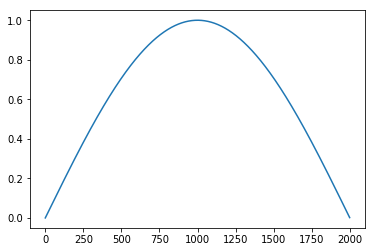

In [23]:
runCbFuncRecord.recorder.plot_lr()
runCbFuncRecord.avg_stats.train_stats, runCbFuncRecord.avg_stats.valid_stats

## Annealer functions from fastai

In [24]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

# Combine schedulers
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner



In [25]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

run = RunnerDJ(cb_funcs=cbfs)
run.fit(3, learn)

NameError: name 'sched' is not defined

In [ ]:
run.recorder.plot_lr()